In [46]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import copy 
import warnings
warnings.filterwarnings('ignore')

In [47]:
#import the data

freedom = pd.read_csv('data_test.csv')
#1540 rows

#clean the data

drop_nan = freedom.drop('Country code', axis=1)
#get rid of first column

freedom1 = drop_nan.apply(pd.to_numeric, errors='coerce')
freedom2 = freedom1.dropna()
#freedom1 is a new dataset where all strings are now NAN
#freedom2 is the new dataframe with all rows containing a '-' removed

index = freedom2.index
number_of_rows = len(index)
print(number_of_rows)
#Code to get number of rows (checking that it hasnt narrowed our data too much)

freedom2.head()
#print(freedom2)

#split the data

train, other = train_test_split(freedom2, test_size=0.2, random_state=0)
validation, test = train_test_split(other, test_size=0.5, random_state=0)
print('The sizes for train, test, and validation is {}'.format((len(train), len(test), len(validation))))
train.head()

x_train = train.drop(columns=['pf_score'])
y_train = train['pf_score']

x_val = validation.drop(columns=['pf_score'])
y_val = validation['pf_score']

x_test = test.drop(columns=['pf_score'])
y_test = test['pf_score']

1163
The sizes for train, test, and validation is (930, 117, 116)


,ef_government_consumption,ef_government_transfers,ef_government_enterprises,ef_government_tax,ef_government_soa,ef_legal_judicial,ef_legal_courts,ef_legal_protection,ef_legal_military,ef_legal_integrity,...,ef_money_sd,ef_money_inflation,ef_money_currency,ef_trade_tariffs,ef_trade_regulatory,ef_trade_movement,ef_regulation_credit,ef_regulation_labor,ef_regulation_business,pf_score
408,8.0,8.1,10.0,9.0,7.4,3.4,3.4,5.5,3.3,6.7,...,9.2,9.3,10.0,7.9,4.2,5.3,6.7,7.1,5.1,6.02
397,4.8,3.5,10.0,3.5,9.5,4.7,2.3,5.0,10.0,6.7,...,9.8,10.0,10.0,8.4,8.1,6.6,9.5,6.8,6.1,8.69
1565,7.7,9.1,8.0,8.0,9.7,3.4,3.9,5.4,5.0,2.5,...,9.6,8.7,10.0,8.2,7.4,6.0,10.0,6.5,6.5,7.27
1139,4.4,6.8,10.0,5.5,9.2,8.5,6.6,7.6,10.0,9.2,...,9.3,9.4,10.0,8.8,8.3,3.0,9.4,7.7,8.0,9.26
134,4.1,8.1,4.0,4.5,8.1,6.1,5.1,5.4,8.3,3.3,...,9.7,9.0,5.0,7.4,5.1,5.0,9.2,6.6,5.8,7.55


In [166]:
#function to calculate the RSS of a linear model

def rss(x, y, a, b):
    '''
    This function calculates the RSS for the model y = a*x + b value given:
    - x: a list
    - y: a list
    - a: a float
    - b: a float
    '''
    x = np.asarray(x) #Cast to numpy array so that we can do arithmatic with arrays
    y = np.asarray(y)
    
    y_predicted = a*x + b # This is an array. Uncomment next line to see
    #print(y_predicted)
    residuals = y - y_predicted
    plt.plot(x, y, 'ro')
    plt.plot(x, y_predicted)
    return sum(pow(residuals, 2))


def tss(y):
    ymean = np.mean(y)
    return sum(pow((y - ymean), 2))

In [39]:
# This is a forward selection function for linear regression
# The main goal is to minimize MSE

def select_column_to_add(x_train, y_train, x_val, y_val, columns_in_model, columns_to_test):
    
    # Model we are going to use
    lr = linear_model.LinearRegression()

    # Setting up variables 
    column_best = None
    columns_in_model = list(columns_in_model)
    errorN = 0
    
    # Setting variable for first iteration
    if len(columns_in_model) == 0:
        errorN = 100

    else:
        # Finding the linear model from training set
        x = x_train[columns_in_model]
        x = np.asarray(x)
        mod = lr.fit(x, y_train)
        y_train_predicted = mod.predict(x)
        
        # Validating the model
        x2 = x_val[columns_in_model]
        x2 = np.asarray(x2)
        y_val_predicted = mod.predict(x2)
        
        # Finding the MSE for validation set
        errorN = mean_squared_error(y_val, y_val_predicted)
    
    # Iterating through all the columns not included in our model
    for column in columns_to_test:
        # Finding the new linear model if a new feature was added
        x = x_train[columns_in_model + [column]]
        x = np.asarray(x)
        mod = lr.fit(x, y_train)
        
        # Predicting the validation set with new model
        y_pred = mod.predict(x_val[columns_in_model+[column]])
        
        # Finding the MSE of new model
        error_new = mean_squared_error(y_val, y_pred)

        # Comparing new MSE with previous MSE
        if errorN - error_new >= 0.005:  # The stopping criteria
            # If the new MSE is lower then new variables are set
            errorN = error_new
            column_best = column

    # After iteration

    # If we found a feature that lowered the MSE
    if column_best is not None:  # Another stopping criteria
        print('Adding {} to the model'.format(column_best))
        print('The smallest mean squared error now is {}'.format(errorN))
        # The best feature is added to the ones we should include in our model  
        columns_in_model_updated = columns_in_model + [column_best]

    # If no feature lowered the MSE beyond our threshold
    else:
        print('Did not add anything to the model')
        # Features in our model stay the same
        columns_in_model_updated = columns_in_model
    
    return columns_in_model_updated, errorN


In [41]:
# Using the forward selection function on all features

# Setting up initial variables for the function
columns_in_model = []
columns_to_test = list(x_train)

# Iterating the function for all features to find the best set of features
for i in range(25):
    output = select_column_to_add(x_train, y_train, x_val, y_val, columns_in_model, columns_to_test)
    columns_in_model = (output[0])


print(columns_in_model)


Adding ef_legal_gender to the model
The smallest mean squared error now is 1.0610441013297411
Adding ef_legal_integrity to the model
The smallest mean squared error now is 0.5680143675891098
Adding ef_money_sd to the model
The smallest mean squared error now is 0.47342501104971757
Adding ef_government_transfers to the model
The smallest mean squared error now is 0.43994765929817836
Adding ef_government_soa to the model
The smallest mean squared error now is 0.41139579683832234
Adding ef_legal_police to the model
The smallest mean squared error now is 0.3819465506229238
Did not add anything to the model
Did not add anything to the model
Did not add anything to the model
Did not add anything to the model
Did not add anything to the model
Did not add anything to the model
Did not add anything to the model
Did not add anything to the model
Did not add anything to the model
Did not add anything to the model
Did not add anything to the model
Did not add anything to the model
Did not add anyt

In [160]:
import copy 

# This is a backward selection function for linear regression
# The main goal is to minimize MSE

def select_column_to_remove(x_train, y_train, x_val, y_val, columns_in_model, columns_to_test):
    
    # Model we are going to use
    lr = linear_model.LinearRegression()

    # Setting up variables
    column_worst = None
    columns_in_model = list(columns_in_model)
    errorN = 0
    
    # Finding linear model for training set 
    x = x_train[columns_in_model]
    x = np.asarray(x)
    mod = lr.fit(x, y_train)
    y_train_predicted = mod.predict(x)
    error_forT = mean_squared_error(y_train, y_train_predicted)
    errorsT.append(error_forT)
    
    # Validating the model
    x2 = x_val[columns_in_model]
    x2 = np.asarray(x2)
    y_val_predicted = mod.predict(x2)
    
    # Finding the MSE for validation set
    errorN = mean_squared_error(y_val, y_val_predicted)
    
    # Iterating through all the features included in the model 
    for column in columns_to_test:
    
        # Finding the new linear model if a feature was removed
        columns_in_model2 = copy.deepcopy(columns_in_model)
        columns_in_model2.remove(column)
        x = x_train[columns_in_model2]
        x = np.asarray(x)
        mod = lr.fit(x, y_train)
        
        # Predicting the validation set with new model
        y_pred = mod.predict(x_val[columns_in_model2])
        
        # Finding the MSE for the validation set 
        error_new = mean_squared_error(y_val, y_pred)

        # Comparing new MSE with previous MSE
        if (error_new <= errorN): # The stopping criteria
            # If the new MSE is lower then new variables are set
            errorN = error_new
            column_worst = column

    # After iteration

    # If we found a feature that lowered the MSE when removed 
    if column_worst is not None:  # The other stopping criteria
        print('Removing {} from the model'.format(column_worst))
        print('The smallest mean squared error now is {}'.format(errorN))
        errorsV.append(errorN)
        new_columns_model = copy.deepcopy(columns_in_model)
        new_columns_model.remove(column_worst)
        print(errorsV)
        print(new_columns_model)
        
    # If removing the feature did not change the MSE
    else:
        print('Did not remove anything from the model')
        new_columns_model = copy.deepcopy(columns_in_model)
    
    return new_columns_model, errorN, errors, errorsT


Removing ef_legal_military from the model
The smallest mean squared error now is 0.3806709276564884
[0.3806709276564884]
['ef_government_consumption', 'ef_government_transfers', 'ef_government_tax', 'ef_government_soa', 'ef_legal_judicial', 'ef_legal_courts', 'ef_legal_protection', 'ef_legal_integrity', 'ef_legal_police', 'ef_legal_crime', 'ef_legal_gender', 'ef_money_growth', 'ef_money_sd', 'ef_trade_tariffs', 'ef_trade_movement', 'ef_regulation_credit', 'ef_regulation_labor']
Removing ef_legal_crime from the model
The smallest mean squared error now is 0.37664314298182106
[0.3806709276564884, 0.37664314298182106]
['ef_government_consumption', 'ef_government_transfers', 'ef_government_tax', 'ef_government_soa', 'ef_legal_judicial', 'ef_legal_courts', 'ef_legal_protection', 'ef_legal_integrity', 'ef_legal_police', 'ef_legal_gender', 'ef_money_growth', 'ef_money_sd', 'ef_trade_tariffs', 'ef_trade_movement', 'ef_regulation_credit', 'ef_regulation_labor']
Removing ef_legal_courts from the

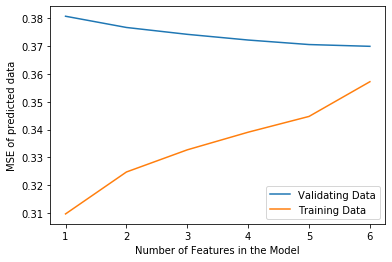

In [178]:
# Using backward selection to find the best linear regression model

# Setting up variables for backward selection function 
columns_to_remove = ['ef_government_enterprises', 'ef_legal_enforcement', 'ef_legal_restrictions', 'ef_money_inflation', 'ef_money_currency', 'ef_trade_regulatory', 'ef_regulation_business']
columns_in_model = list(x_train)
columns_to_test = list(x_train)
errorsV = list()
errorsT = list()

# Removing features previously found to not correlate with the y variable
for cols in columns_to_remove:
    columns_in_model.remove(cols)
    columns_to_test.remove(cols)

# Iterating through all the features to find the best selection of features
for i in range(25):
    output = select_column_to_remove(x_train, y_train, x_val, y_val, columns_in_model, columns_to_test)
    columns_in_model = (output[0])
    columns_to_test = (output[0])

# Plotting MSE against number of features in the model
errorsX = list(range((len(errorsV) + 1)))
errorsX.remove(0)
errorsTp = errorsT[:len(errorsV)]
plt.plot(errorsX, errorsV, label = 'Validating Data')
plt.plot(errorsX, errorsTp, label = 'Training Data')
plt.xlabel('Number of Features in the Model')
plt.ylabel('MSE of predicted data')
plt.legend()



12
0.3572168376414989
0.3698769090271827
0.32053343802731127


Text(0.5, 1.0, 'Backward Selection Method')

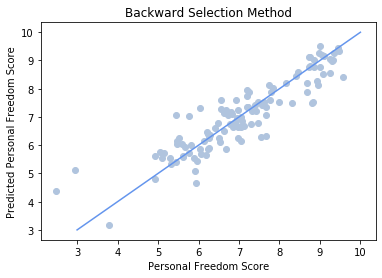

In [200]:
# Finding MSE of linear model found through backward selection

cols_backward = ['ef_government_consumption', 'ef_government_transfers', 'ef_government_tax', 'ef_government_soa', 'ef_legal_judicial', 'ef_legal_protection', 'ef_legal_integrity', 'ef_legal_police', 'ef_legal_gender', 'ef_money_growth', 'ef_money_sd', 'ef_trade_tariffs']
print(len(cols_backward))

x = x_train[cols_backward]
x = np.asarray(x)
mod = lr.fit(x, y_train)
y_train_predicted = mod.predict(x)

print(mean_squared_error(y_train, y_train_predicted))

# validating model

x2 = x_val[cols_backward]
x2 = np.asarray(x2)
y_val_predicted = mod.predict(x2)

print(mean_squared_error(y_val, y_val_predicted))

# testing model

x3 = x_test[cols_backward]
x3 = np.asarray(x3)
y_test_predicted = mod.predict(x3)

print(mean_squared_error(y_test, y_test_predicted))

# Plotting true validated data against predicted validated data

plt.plot(y_val, y_val_predicted, color = 'lightsteelblue', marker = 'o', linestyle = 'None')
xs = [3, 4, 5, 6, 7, 8, 9, 10]
ys = xs
plt.plot(xs, ys, color = 'cornflowerblue')
plt.xlabel('Personal Freedom Score')
plt.ylabel('Predicted Personal Freedom Score')
plt.title('Backward Selection Method')

#RSS = rss(y_val, y_val_predicted, 1, 0)
#TSS = tss(y_val_predicted)
#R2 = 1 - (RSS/TSS)
#print(R2)


In [113]:
# Using forward selection to find the best linear regression model

# Setting up variables for forward selection function 
columns_in_model = []
columns_to_remove = ['ef_government_enterprises', 'ef_legal_enforcement', 'ef_legal_restrictions', 'ef_money_inflation', 'ef_money_currency', 'ef_trade_regulatory', 'ef_regulation_business']
columns_to_test = list(x_train)

# Removing features previously found to not correlate with the y variable
for cols in columns_to_remove:
    columns_to_test.remove(cols)

# Iterating through all the features to find the best selection of features
for i in range(25):
    output = select_column_to_add(x_train, y_train, x_val, y_val, columns_in_model, columns_to_test)
    columns_in_model = (output[0])
    
print(columns_in_model)

Adding ef_legal_gender to the model
The smallest mean squared error now is 1.0610441013297411
Adding ef_legal_integrity to the model
The smallest mean squared error now is 0.5680143675891098
Adding ef_money_sd to the model
The smallest mean squared error now is 0.47342501104971757
Adding ef_government_transfers to the model
The smallest mean squared error now is 0.43994765929817836
Adding ef_government_soa to the model
The smallest mean squared error now is 0.41139579683832234
Adding ef_legal_police to the model
The smallest mean squared error now is 0.3819465506229238
Did not add anything to the model
Did not add anything to the model
Did not add anything to the model
Did not add anything to the model
Did not add anything to the model
Did not add anything to the model
Did not add anything to the model
Did not add anything to the model
Did not add anything to the model
Did not add anything to the model
Did not add anything to the model
Did not add anything to the model
Did not add anyt

6
0.4120922154898639
0.3819465506229238
0.35441348070333345


Text(0.5, 1.0, 'Forward Selection Method')

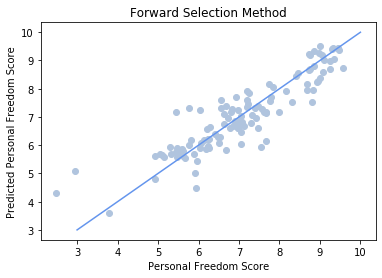

In [197]:
# Finding MSE of linear model found through forward selection

cols_forward = ['ef_legal_gender', 'ef_legal_integrity', 'ef_money_sd', 'ef_government_transfers', 'ef_government_soa', 'ef_legal_police']
print(len(cols_forward))

x = x_train[cols_forward]
x = np.asarray(x)
mod = lr.fit(x, y_train)
y_train_predicted = mod.predict(x)

print(mean_squared_error(y_train, y_train_predicted))

# Validating Model

x2 = x_val[cols_forward]
x2 = np.asarray(x2)
y_val_predicted = mod.predict(x2)

print(mean_squared_error(y_val, y_val_predicted))

# Testing Model

x3 = x_test[cols_forward]
x3 = np.asarray(x3)
y_test_predicted = mod.predict(x3)

print(mean_squared_error(y_test, y_test_predicted))

# Plotting true validated data against predicted validated data

plt.plot(y_val, y_val_predicted, color = 'lightsteelblue', marker = 'o', linestyle = 'None')
xs = [3, 4, 5, 6, 7, 8, 9, 10]
ys = xs
plt.plot(xs, ys, color = 'cornflowerblue')
plt.xlabel('Personal Freedom Score')
plt.ylabel('Predicted Personal Freedom Score')
plt.title('Forward Selection Method')

#RSS = rss(y_val, y_val_predicted, 1, 0)
#TSS = tss(y_val_predicted)
#R2 = 1 - (RSS/TSS)
#print(R2)

In [123]:
print(list(range(2)))

[0, 1]


In [124]:
print(range(2))

range(0, 2)


[-7.10290297e-02 -1.17131640e-01  9.35285590e-04  2.24417325e-01
  3.90904000e-02 -4.86200747e-02  7.88433196e-02  1.29417867e-01
  3.52626893e+00 -9.87877229e-02  9.36373012e-02  1.69097858e-01]


Text(0.5, 1.0, 'Backward Selection Method')

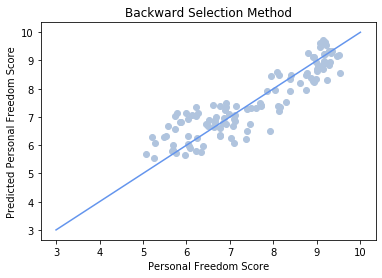

In [201]:
cols_backward = ['ef_government_consumption', 'ef_government_transfers', 'ef_government_tax', 'ef_government_soa', 'ef_legal_judicial', 'ef_legal_protection', 'ef_legal_integrity', 'ef_legal_police', 'ef_legal_gender', 'ef_money_growth', 'ef_money_sd', 'ef_trade_tariffs']

x = x_train[cols_backward]
x = np.asarray(x)
mod = lr.fit(x, y_train)
y_train_predicted = mod.predict(x)

print(mod.coef_)

x3 = x_test[cols_backward]
x3 = np.asarray(x3)
y_test_predicted = mod.predict(x3)

# Plotting true validated data against predicted validated data

plt.plot(y_test, y_test_predicted, color = 'lightsteelblue', marker = 'o', linestyle = 'None')
xs = [3, 4, 5, 6, 7, 8, 9, 10]
ys = xs
plt.plot(xs, ys, color = 'cornflowerblue')
plt.xlabel('Personal Freedom Score')
plt.ylabel('Predicted Personal Freedom Score')
plt.title('Backward Selection Method')

#RSS = rss(y_test, y_test_predicted, 1, 0)
#TSS = tss(y_test_predicted)
#R2 = 1 - (RSS/TSS)
#print(R2)

